# Análisis Exploratorio de Datos - Clasificación de Traducciones,

    Este notebook contiene el análisis exploratorio de los datos de traducciones humanas vs. automáticas.

In [1]:
# Add at the very top of your notebook
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [2]:
# After the initial imports, add:
import torch
print("CUDA available:", torch.cuda.is_available())
print("PyTorch version:", torch.__version__)
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)

CUDA available: True
PyTorch version: 2.5.1+cu118
CUDA device: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA version: 11.8


In [3]:
# GPU/PyTorch imports
import torch
from torch import cuda

# Data processing imports
import pandas as pd
import numpy as np

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# NLP imports
import spacy
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import time

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Cargar el modelo de español
print('Cargando modelo de español...')
nlp = spacy.load('es_core_news_md')
print('Modelo cargado correctamente')

c:\Users\edwar\anaconda3\envs\lab_npl_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cargando modelo de español...
Modelo cargado correctamente


In [4]:
# Leer el archivo txt directamente
data = []
labels = []

with open('../data/TRAINING_DATA.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # Separar por tabulación
        label, text = line.strip().split('\t')
        labels.append(int(label))
        data.append(text)

# Crear el DataFrame
df = pd.DataFrame({
    'label': labels,
    'text': data
})

print(f"Dimensiones del dataset: {df.shape}")
print(f"\nPrimeras 5 muestras:")
df.head()

Dimensiones del dataset: (17877, 2)

Primeras 5 muestras:


,label,text
0,1,"Cuando conocí a Janice en 2013 , una familia n..."
1,0,Hwang habló en Sur de este año por Southwest M...
2,1,Usted podría pensar Katy Perry y Robert Pattin...
3,1,Cualquiera que haya volado los cielos del crea...
4,1,"Bueno , este cantante tendrá un LARGO tiempo p..."


## 1. Distribución de Clases

## Preprocesamiento de datos

In [5]:
import re

# Función de preprocesamiento
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar números
    text = re.sub(r'\d+', '', text)
    # Eliminar signos de puntuación
    #text = re.sub(r'[^\w\s]', '', text)
    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Aplicar preprocesamiento
print("Preprocesando textos...")
df['text_processed'] = df['text'].apply(preprocess_text)
print("Preprocesamiento completado.")

Preprocesando textos...
Preprocesamiento completado.


## 16. Modelos de Transformadores

In [6]:
# At the beginning of your notebook, after the imports, add:
import torch
from torch import cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
if device.type == 'cuda':
    print("CUDA device:", cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)

def train_evaluate_transformer(model_name, X_train, X_test, y_train, y_test):
    print(f"\nIniciando proceso para {model_name}")
    
    try:
        # Cargar tokenizer y modelo
        print("Cargando tokenizer y modelo...")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
        model = model.to(device)
        print("Modelo cargado exitosamente")
        
        # Tokenizar datos
        print("Tokenizando datos...")
        train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
        test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)
        print("Datos tokenizados exitosamente")
        
        # Create tensors and move to GPU
        print("Creando datasets...")
        train_dataset = TensorDataset(
            torch.tensor(train_encodings['input_ids'], device=device),
            torch.tensor(train_encodings['attention_mask'], device=device),
            torch.tensor(y_train.values, dtype=torch.long, device=device)
        )
        test_dataset = TensorDataset(
            torch.tensor(test_encodings['input_ids'], device=device),
            torch.tensor(test_encodings['attention_mask'], device=device),
            torch.tensor(y_test.values, dtype=torch.long, device=device)
        )
        print("Datasets creados exitosamente")
        
        # DataLoader configuration
        batch_size = 32  # Reducido para evitar problemas de memoria
        print(f"Configurando DataLoaders con batch_size={batch_size}")
        num_epoch = 5
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True
        )
        test_loader = DataLoader(
            test_dataset, 
            batch_size=batch_size
        )
        print("DataLoaders configurados exitosamente")
        
        # Optimizer and scaler
        print("Configurando optimizer y scaler...")
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
        scaler = torch.cuda.amp.GradScaler()
        print("Optimizer y scaler configurados")
        
        # Variables para seguimiento del mejor modelo
        best_loss = float('inf')
        best_model_state = None
        
        # Training loop
        print("\nIniciando entrenamiento...")
        model.train()
        for epoch in range(num_epoch):
            print(f"\nEpoch {epoch+1}/{num_epoch}")
            start_time = time.time()
            total_loss = 0
            batch_count = 0
            
            progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epoch}')
            for batch in progress_bar:
                optimizer.zero_grad()
                
                input_ids, attention_mask, labels = batch
                
                with torch.cuda.amp.autocast():
                    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                total_loss += loss.item()
                batch_count += 1
                
                progress_bar.set_postfix({'loss': f'{total_loss/batch_count:.4f}'})
                
                if batch_count % 50 == 0:  # Aumentada la frecuencia de limpieza
                    torch.cuda.empty_cache()
            
            epoch_loss = total_loss/batch_count
            
            # Guardar el mejor modelo
            if epoch_loss < best_loss:
                print(f"Nuevo mejor modelo encontrado. Loss: {epoch_loss:.4f}")
                best_loss = epoch_loss
                best_model_state = model.state_dict().copy()
            
            epoch_time = time.time() - start_time
            print(f'Epoch {epoch+1} completada en {epoch_time:.2f} segundos')
            print(f'Loss promedio: {epoch_loss:.4f}')
        
        # Evaluación final
        print("\nRealizando evaluación final...")
        if best_model_state is not None:
            print("Cargando mejor modelo...")
            model.load_state_dict(best_model_state)
            print("Mejor modelo cargado exitosamente")
        
        def evaluate_model(model, test_loader):
            print("Iniciando evaluación...")
            model.eval()
            all_predictions = []
            all_labels = []
            total_loss = 0
            
            with torch.no_grad():
                for batch in tqdm(test_loader, desc="Evaluando"):
                    input_ids, attention_mask, labels = batch
                    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                    
                    total_loss += outputs.loss.item()
                    predictions = torch.argmax(outputs.logits, dim=1)
                    
                    all_predictions.extend(predictions.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            
            print("Calculando métricas...")
            metrics = {
                'loss': total_loss / len(test_loader),
                'accuracy': accuracy_score(all_labels, all_predictions),
                'classification_report': classification_report(all_labels, all_predictions),
                'predictions': all_predictions,
                'true_labels': all_labels
            }
            print("Evaluación completada")
            
            return metrics
        
        final_metrics = evaluate_model(model, test_loader)
        
        print(f"\nMétricas finales:")
        print(f"Mejor loss: {best_loss:.4f}")
        print(f"Accuracy: {final_metrics['accuracy']:.4f}")
        print("\nReporte de clasificación:")
        print(final_metrics['classification_report'])
        
        return {
            'model': model,
            'best_loss': best_loss,
            'metrics': final_metrics
        }
    
    except Exception as e:
        print(f"\nError durante el proceso:")
        print(f"Tipo de error: {type(e).__name__}")
        print(f"Descripción: {str(e)}")
        print("Stacktrace:")
        import traceback
        traceback.print_exc()
        torch.cuda.empty_cache()
        return None

# Preparar y ejecutar el entrenamiento
print("Preparando datos...")
X_train, X_test, y_train, y_test = train_test_split(
    df['text_processed'], df['label'], 
    test_size=0.2, random_state=42
)
print("Datos preparados exitosamente")

model_configs = {
    #'BETO': 'dccuchile/bert-base-spanish-wwm-uncased',
    'RoBERTa-Spanish': 'BSC-TeMU/roberta-base-bne'
}

results = {}
for name, model_path in model_configs.items():
    print(f"\n{'='*50}")
    print(f"Iniciando entrenamiento de {name}")
    print(f"{'='*50}")
    
    # Limpiar memoria GPU antes de cada modelo
    torch.cuda.empty_cache()
    
    results[name] = train_evaluate_transformer(
        model_path, X_train, X_test, y_train, y_test
    )
    
    # Limpiar memoria GPU después de cada modelo
    torch.cuda.empty_cache()
    print(f"Entrenamiento de {name} completado")

print("\nTodos los entrenamientos completados")

Using device: cuda
CUDA device: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA version: 11.8
Preparando datos...
Datos preparados exitosamente

Iniciando entrenamiento de RoBERTa-Spanish

Iniciando proceso para BSC-TeMU/roberta-base-bne
Cargando tokenizer y modelo...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at BSC-TeMU/roberta-base-bne and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo cargado exitosamente
Tokenizando datos...
Datos tokenizados exitosamente
Creando datasets...
Datasets creados exitosamente
Configurando DataLoaders con batch_size=32
DataLoaders configurados exitosamente
Configurando optimizer y scaler...


C:\Users\edwar\AppData\Local\Temp\ipykernel_62360\3260852642.py:60: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Optimizer y scaler configurados

Iniciando entrenamiento...

Epoch 1/5


Epoch 1/5:   0%|          | 0/447 [00:00<?, ?it/s]C:\Users\edwar\AppData\Local\Temp\ipykernel_62360\3260852642.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/5: 100%|██████████| 447/447 [02:12<00:00,  3.36it/s, loss=0.6095]


Nuevo mejor modelo encontrado. Loss: 0.6095
Epoch 1 completada en 132.85 segundos
Loss promedio: 0.6095

Epoch 2/5


Epoch 2/5: 100%|██████████| 447/447 [02:14<00:00,  3.32it/s, loss=0.4629]


Nuevo mejor modelo encontrado. Loss: 0.4629
Epoch 2 completada en 134.70 segundos
Loss promedio: 0.4629

Epoch 3/5


Epoch 3/5: 100%|██████████| 447/447 [02:11<00:00,  3.39it/s, loss=0.3014]


Nuevo mejor modelo encontrado. Loss: 0.3014
Epoch 3 completada en 131.79 segundos
Loss promedio: 0.3014

Epoch 4/5


Epoch 4/5: 100%|██████████| 447/447 [02:13<00:00,  3.35it/s, loss=0.1824]


Nuevo mejor modelo encontrado. Loss: 0.1824
Epoch 4 completada en 133.24 segundos
Loss promedio: 0.1824

Epoch 5/5


Epoch 5/5: 100%|██████████| 447/447 [02:14<00:00,  3.33it/s, loss=0.1256]


Nuevo mejor modelo encontrado. Loss: 0.1256
Epoch 5 completada en 134.35 segundos
Loss promedio: 0.1256

Realizando evaluación final...
Cargando mejor modelo...
Mejor modelo cargado exitosamente
Iniciando evaluación...


Evaluando: 100%|██████████| 112/112 [00:14<00:00,  7.72it/s]


Calculando métricas...
Evaluación completada

Métricas finales:
Mejor loss: 0.1256
Accuracy: 0.6270

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.61      0.64      0.63      1751
           1       0.64      0.61      0.63      1825

    accuracy                           0.63      3576
   macro avg       0.63      0.63      0.63      3576
weighted avg       0.63      0.63      0.63      3576

Entrenamiento de RoBERTa-Spanish completado

Todos los entrenamientos completados


## Matrices de Confusion


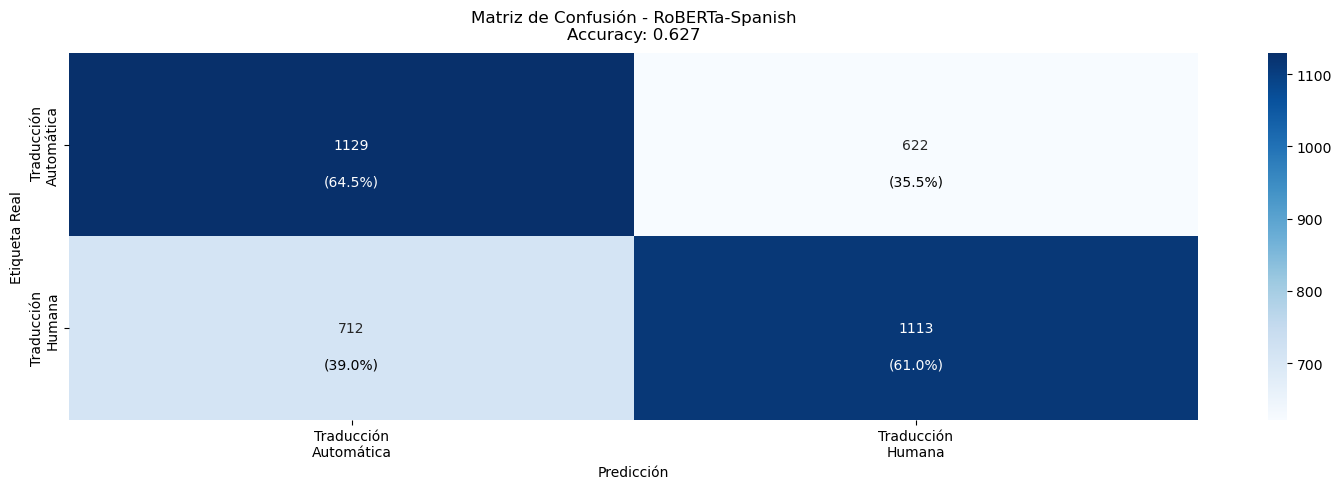


Métricas Detalladas por Modelo:

Modelo: RoBERTa-Spanish
------------------------------
Accuracy: 0.6270
Loss: 0.1256

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.61      0.64      0.63      1751
           1       0.64      0.61      0.63      1825

    accuracy                           0.63      3576
   macro avg       0.63      0.63      0.63      3576
weighted avg       0.63      0.63      0.63      3576


Métricas Adicionales:
Sensibilidad (Recall): 0.6099
Especificidad: 0.6448
Precisión: 0.6415
F1-Score: 0.6253

Matriz de Confusión Desglosada:
Verdaderos Positivos (TP): 1113
Falsos Positivos (FP): 622
Verdaderos Negativos (TN): 1129
Falsos Negativos (FN): 712


In [7]:
# Visualización de Resultados y Matrices de Confusión
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrices(results):
    # Configurar el estilo de las gráficas
    plt.style.use('default')  # Usando estilo default en lugar de seaborn
    
    # Crear subplots para cada modelo
    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(15, 5))
    
    # Si solo hay un modelo, axes no será un array
    if n_models == 1:
        axes = [axes]
    
    # Etiquetas para las clases
    labels = ['Traducción\nAutomática', 'Traducción\nHumana']
    
    for ax, (name, result) in zip(axes, results.items()):
        if result is not None:
            # Obtener predicciones y etiquetas verdaderas
            y_true = result['metrics']['true_labels']
            y_pred = result['metrics']['predictions']
            
            # Calcular la matriz de confusión
            cm = confusion_matrix(y_true, y_pred)
            
            # Calcular porcentajes
            cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
            
            # Crear el heatmap con sns
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                       xticklabels=labels, yticklabels=labels)
            
            # Añadir porcentajes
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax.text(j + 0.5, i + 0.7, 
                           f'({cm_percent[i, j]:.1f}%)',
                           ha='center', va='center',
                           color='black' if cm_percent[i, j] < 50 else 'white')
            
            # Configurar el título y las etiquetas
            ax.set_title(f'Matriz de Confusión - {name}\n'
                        f'Accuracy: {result["metrics"]["accuracy"]:.3f}',
                        pad=10)
            ax.set_ylabel('Etiqueta Real')
            ax.set_xlabel('Predicción')

    plt.tight_layout()
    plt.show()

    # Imprimir métricas detalladas
    print("\nMétricas Detalladas por Modelo:")
    print("="*50)
    
    for name, result in results.items():
        if result is not None:
            print(f"\nModelo: {name}")
            print("-"*30)
            print(f"Accuracy: {result['metrics']['accuracy']:.4f}")
            print(f"Loss: {result['best_loss']:.4f}")
            print("\nReporte de Clasificación:")
            print(result['metrics']['classification_report'])
            
            # Calcular métricas adicionales de la matriz de confusión
            cm = confusion_matrix(result['metrics']['true_labels'], 
                                result['metrics']['predictions'])
            
            # Calcular True Positives, False Positives, True Negatives, False Negatives
            tn, fp, fn, tp = cm.ravel()
            
            # Calcular métricas adicionales
            sensitivity = tp / (tp + fn)  # También conocido como recall
            specificity = tn / (tn + fp)
            precision = tp / (tp + fp)
            f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
            
            print("\nMétricas Adicionales:")
            print(f"Sensibilidad (Recall): {sensitivity:.4f}")
            print(f"Especificidad: {specificity:.4f}")
            print(f"Precisión: {precision:.4f}")
            print(f"F1-Score: {f1:.4f}")
            print("\nMatriz de Confusión Desglosada:")
            print(f"Verdaderos Positivos (TP): {tp}")
            print(f"Falsos Positivos (FP): {fp}")
            print(f"Verdaderos Negativos (TN): {tn}")
            print(f"Falsos Negativos (FN): {fn}")

# Llamar a la función con los resultados
plot_confusion_matrices(results)

## Guardo modelo Roberta con el Fine-tunning

In [11]:
# Después de completar el entrenamiento y evaluación
if 'results' in locals() and 'RoBERTa-Spanish' in results and results['RoBERTa-Spanish'] is not None:
    # Crear directorio para guardar el modelo si no existe
    model_save_path = '../models/roberta_finetuned'
    os.makedirs(model_save_path, exist_ok=True)
    
    print(f"Guardando modelo fine-tuned en {model_save_path}...")
    
    # Guardar el modelo
    model = results['RoBERTa-Spanish']['model']
    model.save_pretrained(model_save_path)
    
    # Guardar el tokenizer
    tokenizer = AutoTokenizer.from_pretrained('BSC-TeMU/roberta-base-bne')
    tokenizer.save_pretrained(model_save_path)
    
    print("Modelo y tokenizer guardados exitosamente!")
    
    # Opcional: Guardar las métricas
    metrics = results['RoBERTa-Spanish']['metrics']
    with open(os.path.join(model_save_path, 'metrics.txt'), 'w') as f:
        f.write(f"Accuracy: {metrics['accuracy']}\n")
        f.write(f"Best Loss: {results['RoBERTa-Spanish']['best_loss']}\n")
        f.write("\nClassification Report:\n")
        f.write(metrics['classification_report'])

Guardando modelo fine-tuned en ../models/roberta_finetuned...
Modelo y tokenizer guardados exitosamente!


## Hacer Predicciones de REAL_DATA.txt

In [12]:
# Configuración del dispositivo y modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_load_path = '../models/roberta_finetuned'  # Ruta donde guardaste el modelo

# Cargar el modelo y tokenizer desde el almacenamiento local
print("Cargando modelo y tokenizer desde almacenamiento local...")
try:
    model = AutoModelForSequenceClassification.from_pretrained(model_load_path)
    tokenizer = AutoTokenizer.from_pretrained(model_load_path)
    print("Modelo fine-tuned cargado exitosamente!")
except Exception as e:
    print(f"Error al cargar el modelo local: {str(e)}")
    print("Cargando modelo base sin fine-tuning...")
    model = AutoModelForSequenceClassification.from_pretrained('BSC-TeMU/roberta-base-bne', num_labels=2)
    tokenizer = AutoTokenizer.from_pretrained('BSC-TeMU/roberta-base-bne')

model = model.to(device)

# Cargar y preprocesar datos
file_path = '../data/REAL_DATA.txt'
try:
    with open(file_path, 'r', encoding='utf-8') as file:
        texts = [line.strip() for line in file if line.strip()]
    
    # Preprocesar textos
    processed_texts = [preprocess_text(text) for text in texts]
    
    # Realizar predicciones
    print("Realizando predicciones...")
    model.eval()
    predictions = []
    batch_size = 32
    
    with torch.no_grad():
        for i in range(0, len(processed_texts), batch_size):
            batch_texts = processed_texts[i:i + batch_size]
            encodings = tokenizer(
                batch_texts,
                truncation=True,
                padding=True,
                max_length=512,
                return_tensors='pt'
            ).to(device)
            
            outputs = model(**encodings)
            batch_predictions = torch.argmax(outputs.logits, dim=1)
            predictions.extend(batch_predictions.cpu().numpy().tolist())
    
    # Convertir predictions a numpy array
    predictions = np.array(predictions)
    
    # Crear DataFrame con resultados
    results_df = pd.DataFrame({
        'texto_original': texts,
        'texto_procesado': processed_texts,
        'prediccion': predictions,
        'tipo_traduccion': ['Traducción ML' if pred == 0 else 'Traducción Humana' 
                           for pred in predictions]
    })
    
    # Mostrar resumen de resultados
    print("\nResumen de Clasificación:")
    print(f"Total de textos analizados: {len(predictions)}")
    print(f"Traducciones ML detectadas: {np.sum(predictions == 0)}")
    print(f"Traducciones humanas detectadas: {np.sum(predictions == 1)}")
    
    # Mostrar distribución
    print("\nDistribución de predicciones:")
    print(results_df['tipo_traduccion'].value_counts())
    
    # Mostrar ejemplos
    print("\nPrimeros 5 ejemplos:")
    display(results_df.head())
    
    # Guardar resultados
    output_path = '../data/resultados_clasificacion2.csv'
    results_df.to_csv(output_path, index=False)
    print(f"\nResultados guardados en: {output_path}")

except FileNotFoundError:
    print(f"Error: No se encontró el archivo {file_path}")
except Exception as e:
    print(f"Error durante la ejecución: {str(e)}")
    import traceback
    traceback.print_exc()
finally:
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

Cargando modelo y tokenizer desde almacenamiento local...
Modelo fine-tuned cargado exitosamente!
Realizando predicciones...

Resumen de Clasificación:
Total de textos analizados: 2201
Traducciones ML detectadas: 1142
Traducciones humanas detectadas: 1059

Distribución de predicciones:
tipo_traduccion
Traducción ML        1142
Traducción Humana    1059
Name: count, dtype: int64

Primeros 5 ejemplos:


,texto_original,texto_procesado,prediccion,tipo_traduccion
0,2\tYo no creo que a nadie le haya encantado un...,yo no creo que a nadie le haya encantado un pe...,1,Traducción Humana
1,2\tNo va a resolver sus problemas de crédito o...,no va a resolver sus problemas de crédito o me...,0,Traducción ML
2,2\tTe encantará este !,te encantará este !,1,Traducción Humana
3,2\tYo estaba a volar a un aeropuerto varias ho...,yo estaba a volar a un aeropuerto varias horas...,1,Traducción Humana
4,"2\t( Maid En Manhattan , The Wedding Planner ,...","( maid en manhattan , the wedding planner , je...",0,Traducción ML



Resultados guardados en: ../data/resultados_clasificacion2.csv
